<a href="https://colab.research.google.com/github/im-ant/COMP767-PGM/blob/master/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mnist VAE

Building a VAE and testing it on Mnist data

Some userful guide:
- https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
  - (actual github): https://github.com/wiseodd/generative-models/blob/master/VAE/vanilla_vae/vae_pytorch.py
- (higher level explanation) http://kvfrans.com/variational-autoencoders-explained/
- Basic Pytorch training example: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Computing KL to a unit Gaussian: https://stats.stackexchange.com/questions/318184/kl-loss-with-a-unit-gaussian
- Next step: conditional VAE:
  - https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/
  - https://graviraja.github.io/conditionalvae/#




In [198]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

# Check for GPU availability
torch.cuda.is_available()

True

In [199]:
# Import Mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)


print(type(mnist))

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>


In [0]:
## Hyperparameters

Z_DIM = 100
X_DIM = mnist.train.images.shape[1]
LAB_DIM = mnist.train.labels.shape[1]
H_DIM = 128


In [0]:
### Building the VAE ###

class Vae(nn.Module):
  # Constructor
  def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
    super(Vae, self).__init__()
    # Attributes
    self.input_d = input_dim
    self.hidden_d = hidden_dim
    self.latent_d = latent_dim
    self.output_d = output_dim
        
    
    # Encoder layers
    self.fc1 = nn.Linear(self.input_d, self.hidden_d)
    self.relu1 = nn.ReLU()
    self.mu = nn.Linear(self.hidden_d, self.latent_d)
    self.log_var = nn.Linear(self.hidden_d, self.latent_d)
    
    # Decoding layers
    self.fc2 = nn.Linear(self.latent_d, self.hidden_d)
    self.relu2 = nn.ReLU()
    self.output = nn.Linear(self.hidden_d, self.output_d)    
    self.sigmoid = nn.Sigmoid()
    
  
  # Encoder
  def encode(self, x):
    h = self.relu1( self.fc1(x) )
    mean = self.mu(h)
    log_variance = self.log_var(h) # log variance for easier computation later
    
    return mean, log_variance
  
  
  # Sampler
  def sample_z(self, mean, log_variance):
    eps = torch.randn((self.latent_d))
    z = mean + (torch.exp(log_variance / 2) * eps)
    
    return z
  
  
  # Decoder
  def decode(self, z):
    h = self.relu2( self.fc2(z) )
    y = self.sigmoid( self.output(h) )
    
    return y
  
    
    

In [0]:
## Training initialization

EPOCHS = 20000
MINBATCH_SIZE = 256
LEARNING_RATE = 1e-3


# Model and solver
model = Vae(X_DIM, H_DIM, Z_DIM, X_DIM)
solver = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Keep track of losses
kl_perEpoch = []
recon_perEpoch = []

In [272]:
epoch_modulo = 1000

## Training begins ##
for ep in range(20000):
  ## Get current batch of training data
  X, _ = mnist.train.next_batch(MINBATCH_SIZE)
  X = Variable(torch.from_numpy(X))
  
  # Zero the optimizer gradient
  solver.zero_grad()
  
  ## Forward pass
  mu_vec, log_var_vec = model.encode(X)
  z_vec = model.sample_z(mu_vec, log_var_vec)
  pred_X = model.decode(z_vec)
  
  
  ## Loss
  # Reconstruction loss
  #recon_loss = F.mse_loss(pred_X, X)
  #recon_loss = F.binary_cross_entropy(pred_X, X, reduction='mean') #hacky? what does this even mean?
  recon_loss = F.binary_cross_entropy(pred_X, X, reduction='sum') / MINBATCH_SIZE
  
  # Compute KL loss to a unit Gaussian:
  # First sum loss for each example, then average over minibatch of examples
  #kl_loss = torch.mean(0.5*torch.sum( (torch.exp(log_var_vec) + (mu_vec**2) - log_var_vec - 1), 1))
  kl_loss = torch.mean(0.5 * torch.sum(torch.exp(log_var_vec) + mu_vec**2 - 1. - log_var_vec, 1))
  
  loss = recon_loss + kl_loss
  
  # Backward
  loss.backward()
  solver.step()
  
  
  # Housekeeping
  if (ep+1) % epoch_modulo == 0:
    print('Epoch %d out of %d' % (ep+1, EPOCHS), end='\t')
    print('Loss: %f' % loss)
  
  recon_perEpoch.append(float(recon_loss))
  kl_perEpoch.append(float(kl_loss))


Epoch 1000 out of 20000	Loss: 109.537361
Epoch 2000 out of 20000	Loss: 105.786659
Epoch 3000 out of 20000	Loss: 105.718666
Epoch 4000 out of 20000	Loss: 110.754227
Epoch 5000 out of 20000	Loss: 104.526520
Epoch 6000 out of 20000	Loss: 110.722557
Epoch 7000 out of 20000	Loss: 110.544876
Epoch 8000 out of 20000	Loss: 106.388741
Epoch 9000 out of 20000	Loss: 108.694923
Epoch 10000 out of 20000	Loss: 106.883690
Epoch 11000 out of 20000	Loss: 105.373863
Epoch 12000 out of 20000	Loss: 113.357376
Epoch 13000 out of 20000	Loss: 113.137680
Epoch 14000 out of 20000	Loss: 106.573837
Epoch 15000 out of 20000	Loss: 116.738571
Epoch 16000 out of 20000	Loss: 113.534622
Epoch 17000 out of 20000	Loss: 105.765343
Epoch 18000 out of 20000	Loss: 112.487297
Epoch 19000 out of 20000	Loss: 109.959808
Epoch 20000 out of 20000	Loss: 111.776031


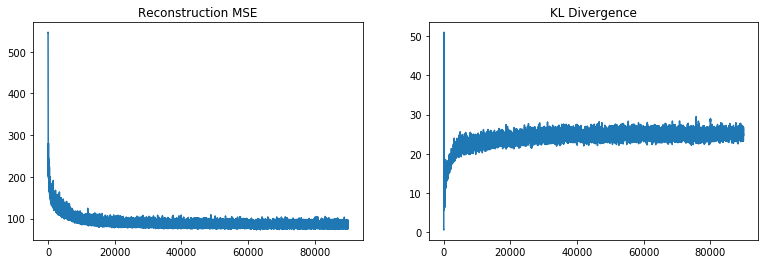

In [273]:
## Visualize loss

plt.figure(figsize=(13, 4))

plt.subplot(1,2,1)
plt.plot(recon_perEpoch)
plt.title('Reconstruction MSE')

plt.subplot(1,2,2)
plt.plot(kl_perEpoch)
plt.title('KL Divergence')

plt.show()

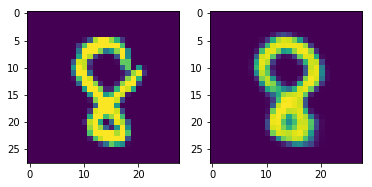

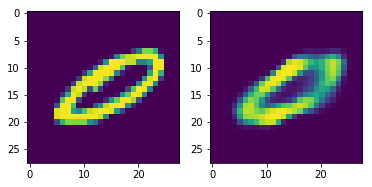

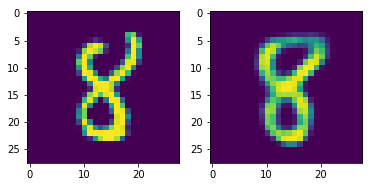

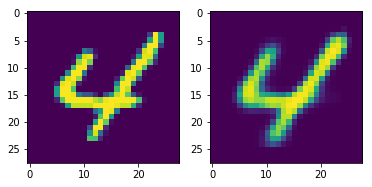

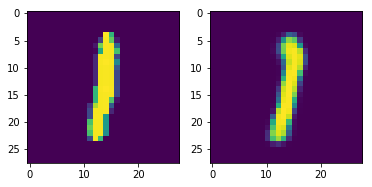

In [274]:
## Visualize some input and output ##

Num_Examples = 5
imgDim = ( int(np.sqrt(X_DIM)), int(np.sqrt(X_DIM)) )

for n_ex in range(1, Num_Examples+1):
  ## Get current batch of training data
  test_x, test_y = mnist.test.next_batch(1)
  test_x = Variable(torch.from_numpy(test_x))
  
  
  # Map to latent
  test_mu_vec, test_log_var_vec = model.encode(test_x)
  test_z_vec = model.sample_z(test_mu_vec, test_log_var_vec)
  pred_test_x = model.decode(test_z_vec)
  
  # Original and reconstructed images
  ori_img = test_x.view(imgDim).data
  recon_img = pred_test_x.view(imgDim).data
  
  # Plot
  plt.subplot(1,2,1)
  plt.imshow(ori_img)
  
  plt.subplot(1,2,2)
  plt.imshow(recon_img)
  
  
  plt.show()
  

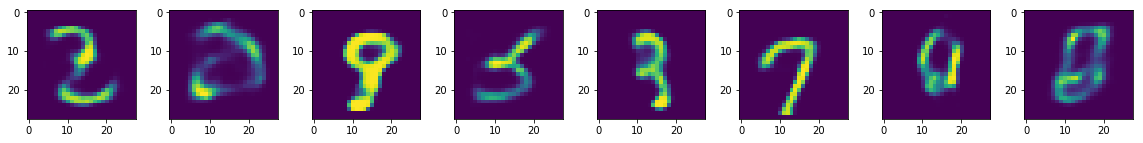

In [275]:
## Output from sampling unit gaussian ##

Num_Examples = 8
imgDim = ( int(np.sqrt(X_DIM)), int(np.sqrt(X_DIM)) )


plt.figure(figsize=(20, 2))


for n_ex in range(1, Num_Examples+1):
  unitGaus_sample = torch.randn((Z_DIM))
  cur_out_x = model.decode(unitGaus_sample)
  
  cur_img = cur_out_x.view(imgDim).data
  
  plt.subplot(1,Num_Examples, n_ex)
  plt.imshow(cur_img)

plt.show()

  